# Recommendation System for Stack Overflow Users
## Table of Contents
1. [Introduction](#Introduction)
2. [Recommending Users Questions from One Question](#Recommending-Users-Questions-from-One-Question)
    1. [Obtaining the Data](#Obtaining-the-Data)
    2. [Recommendations via Jaccard Indices](#Recommendations-via-Jaccard-Indices)
    3. [Recommendations via Cosine Similarity](#Recommendations-via-Cosine-Similarity)
3. [Recommending Questions Given Multiple Questions](#Recommending-Questions-Given-Multiple-Questions)
4. [Conclusion](#Conclusion)

# Introduction
Any company providing services through the internet faces a daunting challenge: how does one keep customers coming back in a world where time and attention are becoming increasingly limited? Designing a convenient, user-friendly website and effective advertising will only go so far if users do not see a need to engage with the company's services. So if Company A wants to keep users coming back, what better way to do this than by showing users similar items they might enjoy? For example, a music streaming service can increase the likelihood users coming back by recommending them songs from their favorite genre. This is the idea behind many [recommender systems](https://en.wikipedia.org/wiki/Recommender_system). In this project, I will create a simple recommender system to recommend questions for [Stack Overflow](https://stackoverflow.com) (SO) users.

It is worth noting that there are many different questions one can answer with recommender systems. Many of the efficient, effective approaches to answering "big questions" such as, "if a user is asking a question, can we show them similar questions?" or "Based on the text in the user's question, can we recommend what tags they should attach to the question?" require the use of [natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP). Eventually I would like to answer those questions using NLP, but since I am still learning about different NLP techniques, I will postpone using any NLP approaches.

Instead, I seek to do the following: if a SO user has asked at least one question on the site, what is a good way to recommend them other questions that they find interesting. Ideally, if we can find more relevant questions for a user, they will find those questions interesting and look at them - or better yet, answer them!

To accomplish this goal, I will be building a [content-based](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering) recommender system. Since I do not have access to all of SO's stored questions and users, I will query the [Stack Exchange Data Explorer](https://data.stackexchange.com) to obtain a random sample of SO users (stored as user IDs), the ID of every question that each one of those users have asked, the tags used on each question, and the title of each question. Then, to recommend questions given a question, I will take a randomly selected question from a separate Data Explorer query as input. Using this random input, I will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) to determine which questions in the larger sample are most similar to the input. Conveniently, the [last project](https://nbviewer.org/github/daniel-rossano/Data-Analysis-Projects/blob/main/Visualizing%20Stack%20Overflow%20Tags/Visualizing%20Stack%20Overflow%20Tags%20Using%20KeplerMapper.ipynb) provides much of the information needed to find the Jaccard index of the questions. This also ties into the [persistent homology project](https://github.com/daniel-rossano/Data-Analysis-Projects/blob/main/Persistent%20Homology%20SO%20Tags/Persistent%20Homology%20of%20Stack%20Overflow%20Tags.ipynb) I did, because that project used the Jaccard index to represent Stack Overflow tags as an abstract metric space. My idea to use Jaccard indices to determine similar questions may be too limited as an abstract, discrete measure to produce meaningful results, so I will compare those results to a more traditional method of determining similarity: [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). 

Finally, I will upscale the problem and recommend questions to a random user who has made multiple questions. I will represent a user's questions as vectors, then take the average of those vectors and check its cosine similarity with the sample questions. This is a more realistic approach, since it is likely that just one question alone is not enough to recommend questions to a user, so multiple questions from the same user give a better undesrtanding of what content is relevant to them.

# Recommending Users Questions from One Question
## Obtaining the Data
A more descriptive, yet still concise overview of how I want to recommend questions from a given question is as follows:
* Query the Stack Overflow Data Explorer for a random sample of Stack Overflow User IDs, as the IDs for every question that each user has made, the tag(s) attached to each of those questions, and the title of each question. The query I use will specifically ignore users who have not made any questions, as such users would essentially "take up empty space" in the sample and leave room for greater inaccuracies in the recommendations. Keep in mind that since the Data Explorer limits fetches only up to $50,000$ rows, our sample is limited to that same number of rows.
* Consider two questions to be similar if their tag(s) have a sufficiently large Jaccard index, i.e., two questions are similar if they use several of the same tags
* For a given question, we will look at its Jaccard index with all other questions in the sample, and then report back the $10$ most similar questions ($10$ questions with the highest Jaccard index). We will, of course, exclude the input if it happens to be in the sample. Afterwards we'll retry the expirment using cosine similarity and (hopefully) obtain similar if not identical answers.

Since the SQL query here is more advanced than in the previous projects, where I only needed to obtain a random sample of any type of post with a nonzero number of tags, I will explicitly write the query I used to obtain all the necessary information:

`SELECT 
    Users.Id AS 'User ID', 
    Posts.Id AS 'Question ID', 
    Posts.Tags AS 'Tags',
    Posts.Title AS 'Question Title'
FROM 
    (SELECT TOP 50000 Users.Id FROM Users ORDER BY NEWID()) AS Users
JOIN 
    Posts ON Posts.OwnerUserId = Users.Id
WHERE
    Posts.PostTypeId = 1
    AND Posts.DeletionDate IS NULL
    AND Posts.ClosedDate IS NULL
    AND Posts.CommunityOwnedDate IS NULL
`

This query fetches a random assortment of users, each of whom has made at least one question. Each row is a user's ID, a question they have made, the tags they've used for that question, and the title for each question. The last few lines narrow down what criteria we allow for questions. The line `Posts.PostTypeId = 1` means we will only consider Stack Overflow *questions* and not articles or answers, because if the end-goal is user *engagement*, I should recommend them something they can participate in. Users should also be recommended questions that have not been deleted or already closed, so that they actulaly have a chance to engage in discussions, hence the lines `AND Posts.DeletionDate IS NULL` and `Posts.ClosedDate IS NULL`. Finally, `AND Posts.CommunityOwnedDate IS NULL` filters out any Community Wiki posts, mostly because such posts are generally more complex to answer, and newer users may feel overwhelmed. In an ideal world where I had direct access to all of the nesessary SO data, I would also filter questions based on creation date, as newer questions ensure the user will have a fair chance to engage in discussion.

## Recommendations via Jaccard Indices
Recall that the Jaccard index of two finite sets $A$ and $B$ is given by $\frac{|A \cap B|}{|A \cup B|}$, where $| \cdot |$ denotes the cardinality of a set. If the two sets have identical elements, their Jaccard index is $1$, but if they have no common elements, their Jaccard index is $0$. To apply this notion of similarity to SO questions, we simply treat the tags on each question as a set. As an example, suppose we have three questions $A$, $B$, and $C$ with the following tags:

Question $A$ tags: $\{$"Java", "Python", "SQL"$\}$

Question $B$ tags: $\{$"Python", "SQL", "SQLite"$\}$

Question $C$ tags: $\{$"Java", "JFrame", "Swing"$\}$

Then the Jaccard index of $A$ and $B$ is $\frac{2}{3}$, while the Jaccard index of $A$ and $C$ is $\frac{1}{3}$, implying questions $A$ and $B$ are more similar than $A$ and $C$.

With that explanation, we have all the information needed to create a question recommendation system. This can be done surprisingly quickly, in very few lines of code. The input will be a question I obtained at random from the Data Explorer, reusing the same `WHERE` clause for questions in the sample. 

In [316]:
import pandas as pd
import re

#read in the sample and the input question
questions = pd.read_csv("UserQuestionSample.csv")
input_question = pd.read_csv("RandomQuestion.csv")

#the SEDE stores tags as one string "<tag1><tag2><tag3>"; its easier to work with them if we split them up into a list
input_tag_list = re.findall(r'<(.*?)>', input_question['Tags'].values[0])
questions['Tag_List'] = questions.Tags.map(lambda tags: re.findall(r'<(.*?)>',tags))

#technically we could drop the 'Tags' column in both dataframes now, but it is superfluous for a project this size


#initialize jaccard_index dataframe; all we need to track are the question IDs and their titles
jaccard_indices = pd.DataFrame(columns = ['Question ID', 'Jaccard Index', 'Question Title', 'Tags'], index = questions.index) 
jaccard_indices['Question ID'] = questions['Question ID']
jaccard_indices['Question Title'] = questions['Question Title']
jaccard_indices['Tags'] = questions['Tag_List']

#map jaccard indices (of each sample question with the input) into this new dataframe
jaccard_indices['Jaccard Index'] = questions.Tag_List.map(lambda x: len(set(x).intersection(set(input_tag_list)))/len(set(x).union(set(input_tag_list))))

#now sort by the 10 questions with highest Jaccard indices with the input
jaccard_indices.sort_values(by = 'Jaccard Index', ascending = False).head(10)

,Question ID,Jaccard Index,Question Title,Tags
14311,23829363,1.000000,Does compiler saves argument of a function?,"[ios, objective-c, objective-c-blocks]"
5473,13511502,1.000000,Objective-C type-check a block?,"[objective-c, ios, objective-c-blocks]"
14412,25959438,0.666667,Collection view scroll with animation causing ...,"[ios, objective-c]"
25240,37156761,0.666667,How can I call an instance method from within ...,"[ios, objective-c]"
14381,23653231,0.666667,Clearing memory when removing a viewController,"[ios, objective-c]"
34588,40124031,0.666667,"On Back app crashes not working in 6s, at MBPr...","[ios, objective-c]"
14394,25913666,0.666667,Understanding a basic thing with Auto-Layout,"[ios, objective-c]"
14408,25957297,0.666667,Get a screen shot of UICollectionView only?,"[ios, objective-c]"
14411,25958474,0.666667,NSCache-not always cleaned?,"[ios, objective-c]"
21639,26787255,0.666667,Third-party library into iOS,"[ios, objective-c]"


In [317]:
#compare titles above with tags and title of the input question:
input_question.loc[0,'Question Title'] + " | " + str(input_tag_list)

"Is accessing instance variables by reference safe? | ['ios', 'objective-c', 'objective-c-blocks']"

We can see that, for minimal effort, we've obtained a list of the $10$ questions with highest Jaccard similarity to the input question. In an ideal world, I'd also output the hyperlinks to each question, but that felt like a tangential step compared to the main goals of the project. Furthermore, there are a few issues with this approach that should be addressed before the fine details:
1. There are only $1-6$ tags used on each question, meaning there is a high chance that hundreds, if not thousands of questions will have the same similarity to the input. In such cases, how do we narrow down which questions to recommend?
2. If there is only $1$ tag used in either the input question, how can we truly determine similarity? For example, if our input is tagged with only "javascript," and asks how to handle errors in javascript, how do we make sure our recommendations yield javascript-related questions with similar content and not irrelevant javascript-related questions like, "how do I declare variables in javascript"?
3. Conversely, if a question in the sample has only one tag, how do we determine if it is actually relevant to the input? If our input question is tagged with "python", "pandas", and "dataframe", and asks "How do I reshape a DataFrame using pandas?", it is possible that one of our sample questions asks the exact same thing, but is only tagged with "python" and will therefore seem irrelevant due to its Jaccard similarity of $\frac{1}{3}$ with the input.

One can reduce some complications of the first issue by handling ties appropriately: if we are at spot $n$ in the top $10$ list, then there are $10-n$ many spots left. But if there are more than $(10-n)$-many ties for that $n$-th spot, then instead of returning the first $10-n$ results as they appeared in the sample, we should choose $10-n$ results *randomly*. Of course, this does not alleviate the problem entirely, but I think it is important to worry about the issue of multiple ties now, as it will be good to have a function we can re-use should this be a problem in the subsequent experiments.

Rather than create a function that just looks at `jaccard_indices['Jaccard Index']`, I decided to generalize the problem because it is not particularly difficult and will likely be helpful during other parts of this project. The following is a function that will take all (numerical) values in a given column for a given DataFrame `df`, sort them in descending order, look for ties only among the top `num_rows` spots, and in cases where there are more ties than open spots, the function will randomly select which rows to use and return the "possibly randomized top `num_rows`" rows.

In [318]:
import numpy as np
def get_top_rows(df, column, num_rows):
    # Sort the dataframe by descending values in the given column
    df_sorted = df.sort_values(by=column, ascending=False)
    
    # Identify the smallest value in the top num_rows
    smallest_top_value = df_sorted.iloc[num_rows - 1, df.columns.get_loc(column)]

    # All rows with values greater than smallest_top_value should be included
    guaranteed_rows = df_sorted[df_sorted[column] > smallest_top_value]

    # Identify rows that are tied for the last spot
    tied_rows = df_sorted[df_sorted[column] == smallest_top_value]

    # If there are more tied rows than spots left, randomly choose rows
    if len(tied_rows) > num_rows - len(guaranteed_rows):
        tied_rows = tied_rows.sample(n=num_rows - len(guaranteed_rows), replace=False)

    # Combine the guaranteed rows with the randomly chosen tied rows
    top_rows = pd.concat([guaranteed_rows, tied_rows])

    return top_rows

Note that `get_top_rows` will always return the largest `num_rows`  rows, even when there are *at most* $($ `num_rows` $- n)$-many ties for the $n$-th spot. In such cases it will be the same as using `df.sort_values(by = column, ascending = False)`, so I will always call `get_top_rows` for the top $10$ spots going forward. Here is a test with the `jaccard_indices` DataFrame. Feel free to compare the randomized Jaccard index table with the one already printed above!

In [319]:
get_top_rows(jaccard_indices, 'Jaccard Index', 10)

,Question ID,Jaccard Index,Question Title,Tags
14311,23829363,1.000000,Does compiler saves argument of a function?,"[ios, objective-c, objective-c-blocks]"
5473,13511502,1.000000,Objective-C type-check a block?,"[objective-c, ios, objective-c-blocks]"
14471,25115492,0.666667,Get iPad version by hardware- which string is ...,"[ios, objective-c]"
11509,21510434,0.666667,Getting the location data and send to server i...,"[ios, objective-c]"
14478,25138404,0.666667,Presenting viewController with transition is n...,"[ios, objective-c]"
26399,32302891,0.666667,iOS: Changing the background image on tap gesture,"[ios, objective-c]"
15594,26719831,0.666667,White color is complete Yellow on iPhone4?,"[ios, objective-c]"
14288,23856711,0.666667,Photo album and editing?,"[ios, objective-c]"
14381,23653231,0.666667,Clearing memory when removing a viewController,"[ios, objective-c]"
15808,27227430,0.666667,Change UISlider background with code,"[ios, objective-c]"


## Recommendations via Cosine Similarity
Properly handling ties is important, but it is also important to find a more nuanced way to recommend relevant questions from a given question. It is possible that something as abstract as the Jaccard index is not capable of capturing such nuances as the three issues I mentioned earlier. I want to "confirm" results as best I can by attempting to back up the Jaccard similarities with another approach to this problem, and I suspect vectorizing the questions and checking their cosine similarities with the input is a good way to do this. While there are many ways to handle a vectorized approach to this problem, many of them use NLP to ensure high accuracy of the vector representation. As I mentioned in the introduction, the goal of this project is to avoid using NLP techniques, so instead I will use a slightly more naive approach: after determining all $n$ distinct tags, both in the input and in the sample, I will represent each question as a binary vector with $n$ components, where the $i$-th component is $0$ if the $i$-th tag is not used in the question and $1$ otherwise. Then, after vectorizing the input question in the same way, I will compute its cosine similarity with all the questions in the sample and report back those with the highest similarity.

The idea behind cosine similarity is a rather simple application of linear algebra: given two vectors $u$ and $v$ of Euclidean space, the dot product $u \cdot v$ is defined by $u \cdot v = \|u\| \|v\| \cos \theta$, where $\| \cdot \|$ is the norm (magnitude) of a vector and $\theta$ is the angle formed by the two vectors $u$ and $v$ (see the picture below).

<br />
<div> 
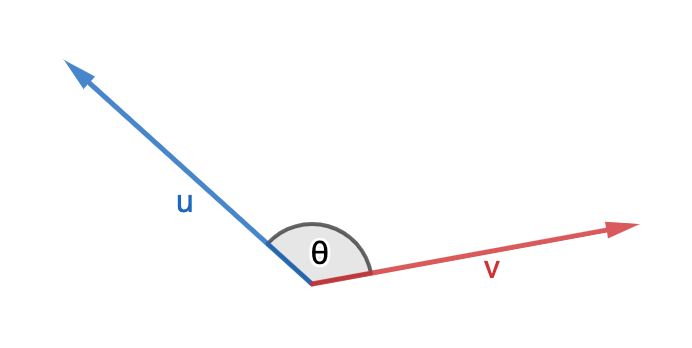 
<div>
    
<br />
This yields the formula $\cos \theta = \frac{u \cdot v}{\|u\| \|v\|},$ which implies $u$ and $v$ have the same orientation when $\cos \theta = 1$, are orthogonal when $\cos \theta = 0$, and have the opposite orientaiton when $\cos \theta = -1$. What this means is that, if we are not concerned with the magnitude of our vectors, we can consider $u$ and $v$ to be similar if $\cos \theta$ is sufficiently close to $1$. It is crucial to note that in any scenario where the magnitude of the vectors is of concern, cosine similarity is likely a bad choice. Two vectors can have the same cosine similarity regardless of their magnitude. It is entirely possible that two vectors with vastly different magnitudes can have cosine similarity of $1$ and therefore be considered quite similar. Given the context of this project, however, cosine similarity is perhaps an ideal fit, as I will now explain.


The use of cosine similarity is justified here because the binary vectors being constructed are a special case (for the mathematically inclined, all the vectors will be bounded by the $n$-dimensional unit hypercube in the strictly positive portion of $n$-dimensional space). There is no need to care about magnitude of the binary question vectors, because their magnitudes differ only by how many tags are used in each question. For example, any question with two tags used will have a magnitude of $\sqrt{2}$, and any question with six tags will have a magnitude of $\sqrt{6}$. But intuitively one would expect that the question have six tags is not inherently irrelevant from the question with two tags -- they may be more closely related than any pair of questions! Additionally, cosine similarity is an efficient way to determine closeness between vectors in higher dimensions, because it does not involve square roots or component-wise operations unlike the traditional Euclidean distance.

Ideally, the cosine similarities will be "close enough" to the Jaccard similarities to confirm that the more abstract method of reccomending questions is not far-fetched. Let's find out!

In [320]:
#first I will check how many distinct tags are in the sample
tag_count = questions['Tag_List'].explode().unique()
len(tag_count)

13482

With at least $13,482$ distinct tags in the sample (the input could potentially have tags not contained in the sample), it would be ideal to have Python libraries to help with the computations. Luckily, [scikit-learn](https://scikit-learn.org) has a class `MultiLabelBinarizer` from the `sklearn.preprocessing` module, which will easily allow me to represent questions as binary vectors in exactly the way described above. Additionally, there's also scikit-learn's aptly named `cosine_similarity` class of the `sklearn.metrics.pairwise` module, which unsurprisingly will allow for efficient computations of the cosine similarity of the vectors.

In [321]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

tag_lists = questions['Tag_List'].tolist() #create list of tag lists to iterate over

#create classes for MLB to map to, i.e., all unique tags from the samples AND the input
tag_classes = list(set(input_tag_list).union(set(questions['Tag_List'].explode().unique())))

#initialize MLB
mlb = MultiLabelBinarizer(classes=tag_classes)

#fit_transform the tag lists AND the input tag list
question_vectors = mlb.fit_transform(tag_lists)
input_vector = mlb.transform([input_tag_list])

#now compute cosine similarities of input with all other vectors from the sample
cosine_similarities = cosine_similarity(input_vector, question_vectors)

In [322]:
#to retreive the top similarities, we'll make a DataFrame from the cosine_similarities, indexed by the question IDs
similarity_table = pd.DataFrame({'Question ID': questions['Question ID'], 'Cosine Similarity' : cosine_similarities[0], 'Jaccard Index' : jaccard_indices['Jaccard Index'], 'Question Title' : questions['Question Title']})

#finally, get and print the top 10 rows with ties randomized as needed
get_top_rows(similarity_table, 'Cosine Similarity', 10)

,Question ID,Cosine Similarity,Jaccard Index,Question Title
14311,23829363,1.000000,1.000000,Does compiler saves argument of a function?
5473,13511502,1.000000,1.000000,Objective-C type-check a block?
15551,27091210,0.816497,0.666667,iOS show notification when something had happe...
15633,26525082,0.816497,0.666667,Rounded UIButton-cant align text
13398,23246383,0.816497,0.666667,why do i use NSURLconnection over loadRequest ...
19424,32203413,0.816497,0.666667,Repeating 3 seconds movies for a help view?
13882,24059817,0.816497,0.666667,How can I get the top-most viewController when...
17798,29039441,0.816497,0.666667,NSURL URLWithString gives error: unrecognized ...
29108,43845802,0.816497,0.666667,View shifted across to the right
14288,23856711,0.816497,0.666667,Photo album and editing?


The above table also includes the Jaccard indices for the respective questions to highlight why cosine similarity is a better refinement! For the most part, many of the same questions appear in the same order, so the Jaccard index approach was not in vain. The different ordering of questions is most likely due to having fewer ties among questions' cosine similarities than with their Jaccard indices. Since the cosine similarity has a larger range of values for this sample (i.e., not just increments of $\frac{1}{6}$ maximum) there are generally going to be fewer ties. One could always handle ties of questions by simply returning them in a random order, but I suspect that any meaningful way to increase the likelihood of relevant recommendations would require NLP.

# Recommending Questions Given Multiple Questions
So far I've answered how we can use non-NLP processes to recommend questions to users based off of a single question. But in reality, one question alone may not be enough to determine exactly what type of content a user is interested in. The single question we obtain may be a question the user asked just to get through their coursework! It would help to be able to analyze multiple questions for the same user and recommend them questions based off of all of their previous questions.

The method employed here may seem familiar: I will take as input a user ID, all the question(s) that user has asked and all the the tag(s) on those question(s). Then using the input tags, I will construct binary vectorizations of the questions in the sample based off of what tags are used in the input questions and the sample. Finally, I will vectorize the input questions and take their average, which is the "question equally similar to all the questions the given user has asked," and I will check the cosine similarity of this vector to all the other question vectors in the sample, reporting back the $10$ question most similar to the average of questions. 

This is almost identical to the process of using cosine similarity to recommend a single question, but with two major changes: I need to vectorize all the questions the given user has asked and average those vectors, and also I need to account for any tags that might not have been included in the sample. Because of the last part, all of the same steps need to be repeated. I used another SQL query to select a random assortment of user IDs, then took one of those IDs and selected the question ID, tags, and title of each non-deleted, non-closed, non-community-owned question they've asked. The only interference I had with this random user is that I ensured they had posted more than one question, so as not to make this extra work unnecessary!

The choice of narrowing down the sample of questions from the given user in the way I explained above arises from the goal of determining what a user is most interested in; while we technically do not need to worry about whether or not a question was deleted or is or is not closed, it is important to realize these choices ensure we're getting only the information the user is most actively engaging in.

In [323]:
import numpy as np

#read in input, then determine tag lists and unique tags for MLB classes
input_user = pd.read_csv("RandomUserQuestions.csv")
input_user_tag_lists = [re.findall(r'<(.*?)>', x) for x in input_user['Tags']]
input_user_classes = set([tags for sublist in input_user_tag_lists for tags in sublist])

#input may contain tags not in the sample, so update tag classes accordingly
new_tag_classes = list(input_user_classes.union(set(questions['Tag_List'].explode().unique())))

#update mlb with new classes
multi_question_mlb = MultiLabelBinarizer(classes = new_tag_classes)

#update question vectors and transform input questions
#recall tag_lists was defined above as each list of tags from the sample
question_vectors = multi_question_mlb.fit_transform(tag_lists)
input_vectors = multi_question_mlb.transform(input_user_tag_lists)

#take transformed input vectors, convert them into a numpy array, then average this array to get the average
input_array = np.array(input_vectors)
input_average = np.mean(input_array, axis = 0)

#take cosine similarities of average user vector with question vectors
#need to reshape the averages because cosine_similarity expects an array with the same # of rows as question_vectors
cosine_sims = cosine_similarity(input_average.reshape(1,-1), question_vectors)

In [324]:
#to retreive the top similarities, we'll make a DataFrame from the cosine_similarities, indexed by the question IDs
avg_similarity_table = pd.DataFrame({'Question ID': questions['Question ID'], 'Cosine Similarity' : cosine_sims[0], 'Question Title' : questions['Question Title'], 'Tags' : questions['Tag_List']})

#finally, get and print the top 10 rows with ties randomized as needed
get_top_rows(avg_similarity_table, 'Cosine Similarity', 10)

,Question ID,Cosine Similarity,Question Title,Tags
23022,33825643,0.602464,How to structure a dynamic query with linq,"[c#, sql, asp.net-mvc, entity-framework, linq]"
10591,17242127,0.555556,Update an item but insert if it does not exists,"[asp.net-mvc, linq, entity-framework]"
14831,25370977,0.555556,Upgrading MVC 4 to MVC 5 connection issue,"[c#, asp.net-mvc, entity-framework]"
46559,67186975,0.555556,How to I add DateTime to my existing database?,"[c#, asp.net-mvc, entity-framework]"
9497,16409498,0.544331,DropDownListFor giving null always,"[asp.net-mvc, entity-framework]"
31713,47084419,0.481125,update parent from child sum records,"[c#, asp.net, asp.net-mvc, entity-framework]"
24914,36266890,0.481125,EntityObject to DbContext,"[c#, asp.net-mvc, entity-framework, extension-..."
13103,15509042,0.444444,"Entity Framework returning null children, unde...","[c#, linq, entity-framework]"
10583,17296663,0.444444,Error with relationship,"[asp.net-mvc, entity-framework, ef-code-first]"
21099,25431728,0.444444,Executing SQL Query on Entity Framework derive...,"[c#, sql, entity-framework]"


In [325]:
#Compare with the question(s) the input user has created:
input_user

,Question ID,Question Title,Tags
0,5629844,"Linked List, searching through",<list><search><recursion>
1,5697128,stack trace in code,<java><stack><trace><prefix><postfix-notation>
2,7557394,Taking a stack and printing it in reverse orde...,<assembly><printing><stack><bit>
3,68821745,Two sql tables referencing each other with nul...,<sql><asp.net-mvc><database><entity-framework>
4,71887601,Sorting a 1-to-many relationship for a log tab...,<c#><asp.net-mvc><entity-framework><linq><data...


# Conclusion

From the tables for `avg_similarity_table` and `input_user`, one can conclude that there are some questions that might be of interest to the given user. The cosine similarities are not particularly high; if I had access to a larger sample of questions I would definitely consider any cosine similarities below a certain value, say, $0.6$, to be irrelevant, but one should keep in mind that cosine similarity may take any values between $-1$ and $1$ inclusive, so questions with similarity $0.444444$ are not inherently ill suited as recommendations.

If I had to revisit this problem in the future, I would certainly do a few things differently. For starters, I would try to find a way to take the weighted average of the questions the input user has asked such that if certain tags appear in multiple questions (the input user here used "entity-framework" multiple times, for instance) then those tags should have more emphasis, since they likely reveal a user's interest(s).

Additionally, I would use [tf-idf](https://en.wikipedia.org/wiki/Tf-idf) or a similar algorithm to vectorize the questions instead of the naive approach I used here. One could also forego a tag-based vectorization of the tags entirely and use either the body of the question or the title (or perhaps both!) with an appropriate NLP algorithm to ensure more accurate results, or even find exact duplicates of a question as it is being written! This is certainly something I want to revisit some day, but for now I need to focus on other things.